In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import cv2
import numpy as np
import torch
from torch.autograd import Variable

from mtcnn.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square
from mtcnn.first_stage import run_first_stage
from mtcnn.get_nets import PNet, RNet, ONet
from mtcnn.visualization_utils import show_bboxes

# Load models

In [35]:
pnet = PNet()
rnet = RNet()
onet = ONet()
onet.eval();

# Set hyperparameters

In [36]:
# if this value is too low the algorithm will use a lot of memory
min_face_size = 15.0  

# for probabilities
thresholds = [0.6, 0.7, 0.8]

# for NMS
nms_thresholds=[0.7, 0.7, 0.7]

# Load an image

In [37]:
image = cv2.imread('images/office5.jpg')
image

array([[[244, 197, 146],
        [245, 198, 147],
        [245, 198, 147],
        ..., 
        [216, 178, 136],
        [218, 180, 138],
        [222, 184, 142]],

       [[244, 197, 146],
        [245, 198, 147],
        [245, 198, 147],
        ..., 
        [214, 181, 142],
        [216, 180, 144],
        [208, 175, 136]],

       [[243, 199, 146],
        [243, 199, 146],
        [244, 200, 147],
        ..., 
        [121,  95,  65],
        [187, 158, 131],
        [209, 183, 153]],

       ..., 
       [[ 29, 147, 136],
        [ 37, 155, 144],
        [ 22, 142, 131],
        ..., 
        [ 16, 111,  97],
        [  3,  98,  84],
        [  4,  99,  85]],

       [[ 35, 153, 142],
        [ 29, 147, 136],
        [ 17, 137, 126],
        ..., 
        [ 22, 117, 103],
        [ 18, 113,  99],
        [ 22, 117, 103]],

       [[ 21, 139, 128],
        [ 22, 140, 129],
        [ 33, 153, 142],
        ..., 
        [ 14, 109,  95],
        [ 20, 115, 101],
        [ 25, 120,

# build an image pyramid

In [38]:
height, width, _ = image.shape
min_length = min(height, width)

min_detection_size = 12
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
scales = []

# scales the image so that
# minimum size that we can detect equals to
# minimum face size that we want to detect
m = min_detection_size/min_face_size
min_length *= m

factor_count = 0
while min_length > min_detection_size:
    scales.append(m*factor**factor_count)
    min_length *= factor
    factor_count += 1

print('scales:', ['{:.2f}'.format(s) for s in scales])
print('number of different scales:', len(scales))

scales: ['0.80', '0.57', '0.40', '0.28', '0.20', '0.14', '0.10', '0.07', '0.05', '0.04']
number of different scales: 10


# P-Net

In [39]:
bounding_boxes = []

# run P-Net on different scales
for s in scales:
    boxes = run_first_stage(image, pnet, scale=s, threshold=thresholds[0])
    bounding_boxes.append(boxes)

# collect boxes (and offsets, and scores) from different scales
bounding_boxes = [i for i in bounding_boxes if i is not None]
bounding_boxes = np.vstack(bounding_boxes)
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 103


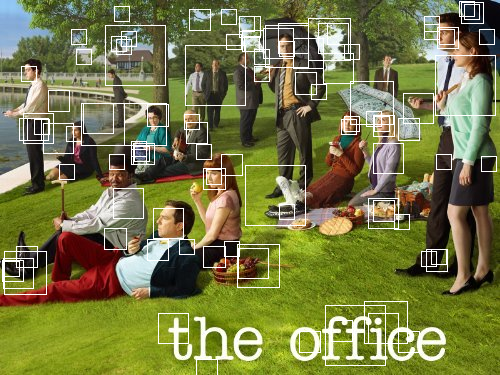

In [40]:
show_bboxes(image, bounding_boxes)

# NMS + calibration

In [41]:
keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
bounding_boxes = bounding_boxes[keep]

# use offsets predicted by pnet to transform bounding boxes
bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
# shape [n_boxes, 5]

bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 103


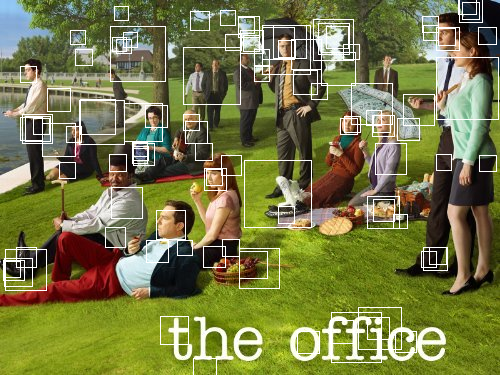

In [42]:
show_bboxes(image, bounding_boxes)

# R-Net

In [43]:
img_boxes = get_image_boxes(bounding_boxes, image, size=24)
img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
output = rnet(img_boxes)
offsets = output[0].data.numpy()  # shape [n_boxes, 4]
probs = output[1].data.numpy()  # shape [n_boxes, 2]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/honza/School/Diplomka/mtcnn-pytorch/mtcnn/get_nets.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


In [44]:
keep = np.where(probs[:, 1] > thresholds[1])[0]
bounding_boxes = bounding_boxes[keep]
bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
offsets = offsets[keep]

print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 7


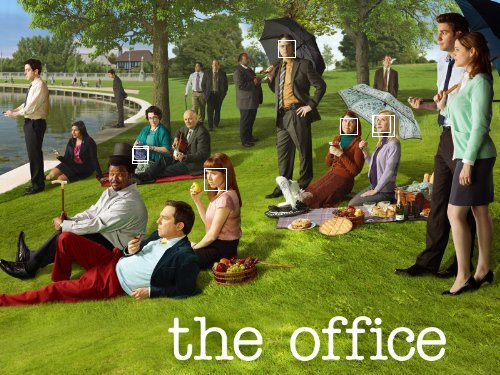

In [45]:
show_bboxes(image, bounding_boxes)

# NMS + calibration

In [46]:
keep = nms(bounding_boxes, nms_thresholds[1])
bounding_boxes = bounding_boxes[keep]
bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 7


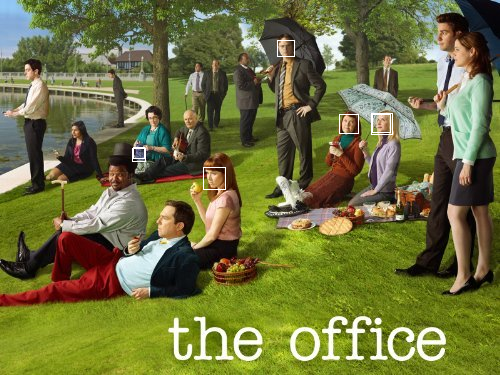

In [47]:
show_bboxes(image, bounding_boxes)

# O-Net

In [48]:
img_boxes = get_image_boxes(bounding_boxes, image, size=48)
img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
output = onet(img_boxes)
landmarks = output[0].data.numpy()  # shape [n_boxes, 10]
offsets = output[1].data.numpy()  # shape [n_boxes, 4]
probs = output[2].data.numpy()  # shape [n_boxes, 2]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/honza/School/Diplomka/mtcnn-pytorch/mtcnn/get_nets.py:169: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


In [49]:
keep = np.where(probs[:, 1] > thresholds[2])[0]
bounding_boxes = bounding_boxes[keep]
bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
offsets = offsets[keep]
landmarks = landmarks[keep]

# compute landmark points
width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]
    
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 3


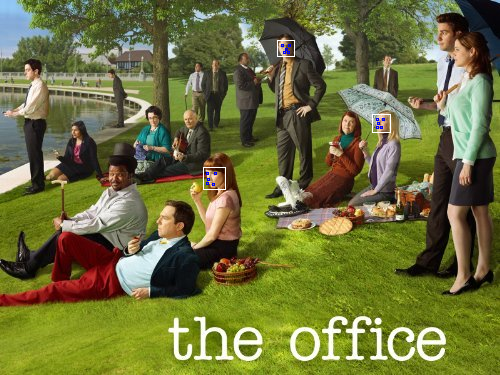

In [50]:
show_bboxes(image, bounding_boxes, landmarks)

# NMS + calibration

In [51]:
bounding_boxes = calibrate_box(bounding_boxes, offsets)
keep = nms(bounding_boxes, nms_thresholds[2], mode='min')
bounding_boxes = bounding_boxes[keep]
landmarks = landmarks[keep]
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 3


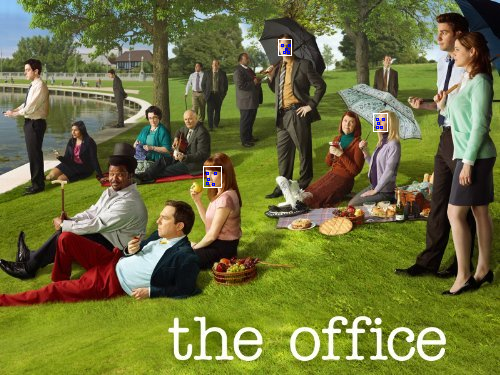

In [52]:
show_bboxes(image, bounding_boxes, landmarks)